In [77]:
import numpy as np
import random
import pygame as pg

random.randrange(10,50)

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


45

In [431]:
from scipy.spatial import distance
import enum 
import copy 

SENSE_FACTOR = 2

class Block:
    def __init__(self):
        self.content = None
    
    def set_content(self, content):
        self.content = content
        
class State(enum.Enum):
    FIND_FOOD = 0
    GO_BACK = 1

class Organism:
    PREDATOR_PREY_RATIO = 1.6
    color = (255, 255, 255)
    food_found = 0
    state = State.FIND_FOOD
    energy = 0
    
    def __init__(self, size, speed, sense, max_w, max_h):
        self.size = size
        self.speed = speed
        self.sense = sense
        
        self.max_w = max_w-1
        self.max_h = max_h-1
        
        a2 = random.random() 
        b2 = 1-a2
        a = np.sqrt(a2) * (2*(0.5>random.random())-1)
        b = np.sqrt(b2) * (2*(0.5>random.random())-1)
        
        self.direction = np.array([1, 0])
        
        # Organism starts at a border
        if random.random() > 0.5:
            x = random.uniform(0, max_w-1)
            y = 0
            if random.random() > 0.5:
                y = max_h-1
        else:
            y = random.uniform(0, max_h-1)
            x = 0
            if random.random() > 0.5:
                x = max_w-1
        self.position = np.array([x, y])
        
    def energy_cost(self):
        return ((self.size**3)*self.speed**2)+self.sense
    
    def get_coordinates(self):
        return self.position
    
    def reproduce(self, energy):
        offspring = copy.deepcopy(self)
        mutation_chance = 0.1
        
        offspring.size += (mutation_chance>random.random())*self.size *random.randrange(10,50)*0.01 * (2*(0.5>random.random())-1)
        offspring.speed += (mutation_chance>random.random())*self.speed*random.randrange(10,50)*0.01 * (2*(0.5>random.random())-1)
        offspring.sense += (mutation_chance>random.random())*self.sense*random.randrange(10,50)*0.01 * (2*(0.5>random.random())-1)
        offspring.energy = energy      
        offspring.state = State.FIND_FOOD
        
        return offspring
    
    def attributes(self):
        return np.array([self.size, self.speed, self.sense])
    
    def closest_border(self):
        borders = [[self.position[0], 0], [self.max_w, self.position[1]], [self.position[0], self.max_h],[0, self.position[1]]]
        distances = distance.cdist([self.get_coordinates()], borders, 'euclidean')[0]
        closest_idx = np.argmin(distances)
        
        return distances[closest_idx], borders[closest_idx][0], borders[closest_idx][1]
    
    def walk(self, env):
        distances = []
        step_size = self.speed
        direction = self.direction
        
        prey = []
        close_predators = []
        for o in env["organisms"]:
            if o == self: continue
            if o.size*self.PREDATOR_PREY_RATIO <= self.size:
                prey.append(o.position)
            if self.size*self.PREDATOR_PREY_RATIO > o.size:
                if np.sqrt(np.sum(o.position**2-self.position**2)) <= (self.sense * SENSE_FACTOR):
                    close_predators.append(o.position)
                        
        food = env["food"] + prey
        if len(food) > 0:
            distances = distance.cdist([self.get_coordinates()], food, 'euclidean')[0]
            closest_idx = np.argmin(distances)
            
        if len(close_predators) > 0:
            pr_distances = distance.cdist([self.get_coordinates()], close_predators, 'euclidean')[0]
            pr_idx = np.argmin(pr_distances)
            
            d = (close_predators[pr_idx] + self.position)*-1
            norm = np.linalg.norm(d)
            if norm == 0:
                return
            direction = d/norm 
            #print("RUN!")
        
        elif self.state == State.GO_BACK:
            dist, x, y = self.closest_border()
            step_size = dist if abs(dist) < step_size else step_size
            
            d = np.array([x, y]) - self.position
            norm = np.linalg.norm(d)
            if norm == 0:
                return
            direction = d/norm   
        elif (len(distances) > 0) and (distances[closest_idx] <= (self.sense * SENSE_FACTOR)):
            step_size = distances[closest_idx] if abs(distances[closest_idx]) < step_size else step_size
            
            d = food[closest_idx] - self.position
            norm = np.linalg.norm(d)
            if norm == 0:
                return
            direction = d/norm           
        else:            
            #x2=cosβx1−sinβy1, y2=sinβx1+cosβy1
            
            r = random.uniform(-.5, .5)#(-np.pi/2, np.pi/2)
            direction = np.array([np.cos(r)*direction[0] - np.sin(r)*direction[1], 
                                  np.sin(r)*direction[0] + np.cos(r)*direction[1]])
            self.direction = direction/np.linalg.norm(direction)
        
        if self.energy >= self.energy_cost():
            self.position += step_size*direction
        
        self.energy -= self.energy_cost()   
    

In [442]:
import numpy as np
import random
import pygame as pg


SCREEN_WIDTH, SCREEN_HEIGHT = 800,600
ENV_WIDTH, ENV_HEIGHT = 100, 80

BACK_COLOR = (100, 100, 100)
BLOCK_COLOR = (200, 200, 200)
MAZE_COLOR = (255, 255, 255)
UNVISITED_COLOR = (200, 200, 200)


BLOCK_SIZE = 5  # Pixel size/Wall thickness

ENV_WIDTH_PX = BLOCK_SIZE * ENV_WIDTH 
ENV_HEIGHT_PX = BLOCK_SIZE * ENV_HEIGHT 
ENV_TOP_LEFT_CORNER = (SCREEN_WIDTH // 2 - ENV_WIDTH_PX // 2, SCREEN_HEIGHT // 2 - ENV_HEIGHT_PX // 2)

MINUTES_PER_DAY = 100
DAY_ENERGY = 25*MINUTES_PER_DAY
REMOVE_EXCESS_FOOD = True


pg.init()
screen = pg.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))

def init_organisms(n, attr):
    organisms = []
    for _ in range(n):
        o = Organism(attr[0], attr[1], attr[2], ENV_WIDTH, ENV_HEIGHT)
        o.energy = DAY_ENERGY
        organisms.append(o)
    return organisms


def draw(color, x, y):
    pg.draw.rect(screen, color, (x+1, y+1, BLOCK_SIZE-1, BLOCK_SIZE-1))

def draw_environment(screen, env):
        screen.fill(BACK_COLOR)
        pg.draw.rect(screen, (0,0,0), (ENV_TOP_LEFT_CORNER[0], ENV_TOP_LEFT_CORNER[1],
                                               ENV_WIDTH_PX, ENV_HEIGHT_PX))
        draw_xy, color = np.array([0,0]), None
        for o in env["organisms"]:
            color = o.color
            draw_xy = o.position*BLOCK_SIZE + ENV_TOP_LEFT_CORNER
            draw(color, draw_xy[0], draw_xy[1])
        for xy in env["food"]:
            color = (0,255,0)
            draw_xy = xy*BLOCK_SIZE + ENV_TOP_LEFT_CORNER
            draw(color, draw_xy[0], draw_xy[1])

def kill(env):
    kill_counter = 0
    
    for o in env["organisms"].copy():
        dist_to_border, _, _ = o.closest_border()
        if (o.energy <= 0) or (dist_to_border > 1):
            env["organisms"].remove(o)
            kill_counter += 1
    #print("{} organisms killed".format(kill_counter))
            
            
def sleep_and_reproduce(env):
    babies = []
    for o in env["organisms"]:
        if o.food_found >= 2:
            babies.append(o.reproduce(DAY_ENERGY))
        o.food_found = 0
        o.energy = DAY_ENERGY
        o.state = State.FIND_FOOD
    env["organisms"].extend(babies)
    #print("{} babies born".format(len(babies)))
                
def do_one_step(env, m):
    minutes_left = MINUTES_PER_DAY - m
    
    attributes = np.array([o.attributes() for o in env["organisms"]])
    max_attr = np.max(attributes)
    
    for o in env["organisms"]:
        o.walk(env)
        pos = o.get_coordinates()
        
        for i, food in enumerate(env["food"]):
            if np.linalg.norm(food-pos)<=0.01:
                env["food"].pop(i)
                o.food_found += 1
                dist_to_border, _, _ = o.closest_border()
                if (o.food_found > 1) or (dist_to_border/o.speed >= minutes_left-5):
                    o.state = State.GO_BACK
                break
        for i, o2 in enumerate(env["organisms"]):
            if o2 == o: continue
            if o.size>= o.PREDATOR_PREY_RATIO*o2.size and np.linalg.norm(o2.position-pos)<=0.01:
                #print("someone is eaten!")
                env["organisms"].pop(i)
                o.food_found += 1
                dist_to_border, _, _ = o.closest_border()
                if (o.food_found > 1) or (dist_to_border/o.speed >= minutes_left-5):
                    o.state = State.GO_BACK
                break
            
        pos = o.get_coordinates()%np.array([(ENV_WIDTH-1), (ENV_HEIGHT-1)])
        #min(max(x,0),ENV_WIDTH-1)
        #min(max(y,0), ENV_HEIGHT-1)
        o.position = pos
        o.color = o.attributes()*255/max_attr
                
def run_simulation():
    pg.display.update()
    
    env = {"food" : [], "organisms" : []}
    n_food = 50
    for f in range(n_food):
        x, y = random.randrange(1,ENV_WIDTH-1), random.randrange(1,ENV_HEIGHT-1)
        env["food"].append(np.array([x, y]))
        
    organisms = init_organisms(40, (1, 1, 1))
    env["organisms"].extend(organisms)
    # Main game loop
    run = True
    
    time_keeper = {"day":0, "minute":0}
    stats = {"population":[len(organisms)], "attributes":[[o.attributes() for o in organisms]]}
    while run:
        for event in pg.event.get():
            if event.type == pg.QUIT:
                run = False
        
        if len(env["organisms"]) == 0:
            run = False
            continue
        
        # do one simulation step
        do_one_step(env, time_keeper["minute"])
        time_keeper["minute"] += 1
        if time_keeper["minute"] >= MINUTES_PER_DAY:
            time_keeper["minute"] = 0
            time_keeper["day"] += 1
            kill(env)
            sleep_and_reproduce(env)
            if REMOVE_EXCESS_FOOD:
                env["food"] = []
            for f in range(n_food):
                x, y = random.randrange(1,ENV_WIDTH-1), random.randrange(1,ENV_HEIGHT-1)
                env["food"].append(np.array([x, y]))
            pg.time.wait(500)
            
            attributes = np.array([o.attributes() for o in env["organisms"]])
            
            stats["population"].append(len(env["organisms"]))
            stats["attributes"].append(attributes)
        
        
        draw_environment(screen, env)
        pg.display.update()
        pg.time.wait(10)
        pg.event.pump()

    pg.quit()
    return stats
    
stats = run_simulation()

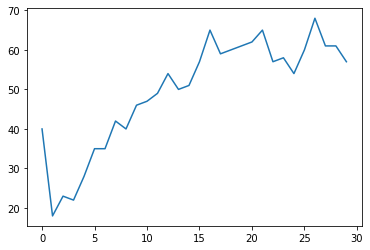

30


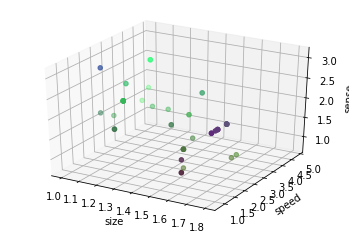

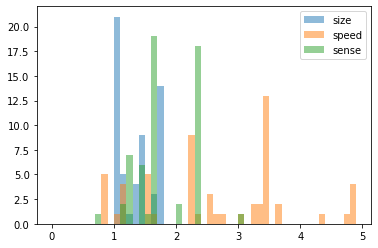

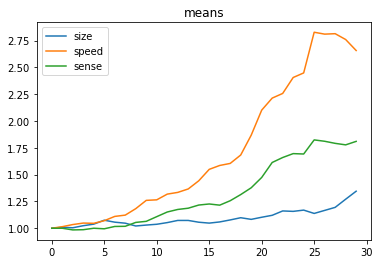

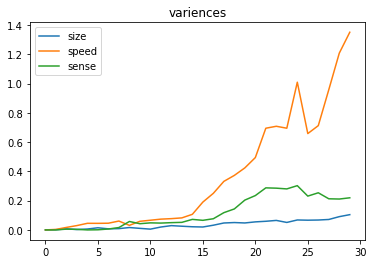

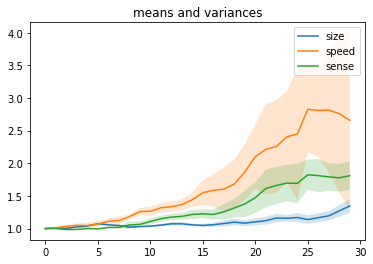

In [507]:
%matplotlib inline

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # for 3D plotting

fig = plt.figure()
plt.plot(np.arange(0,len(stats["population"])), stats["population"])
plt.show()

print(len(stats["attributes"]))
atts = np.array(stats["attributes"][len(stats["attributes"])-1])

si = atts[:,0] 
sp = atts[:,1]
se = atts[:,2]
max_attr = np.max(atts)
colors = np.array(atts/max_attr)

fig2 = plt.figure()
ax = fig2.gca(projection='3d')
ax.scatter(xs=si,ys=sp,zs=se, c = colors)
ax.set_xlabel("size")
ax.set_ylabel("speed")
ax.set_zlabel("sense")
plt.show()

bin_size = 0.1
bins = np.arange(0,np.ceil(max_attr), bin_size)
hist_si, edges = np.histogram(si, bins=bins)
hist_sp, edges = np.histogram(sp, bins=bins)
hist_se, edges = np.histogram(se, bins=bins)
fig = plt.figure()
plt.bar(bins[:-1], hist_si, width=bin_size, align='edge', alpha=.5)
plt.bar(bins[:-1], hist_sp, width=bin_size, align='edge', alpha=.5)
plt.bar(bins[:-1], hist_se, width=bin_size, align='edge', alpha=.5)
plt.legend(["size", "speed", "sense"])
plt.show()

#print([atts.shape for atts in stats["attributes"]])
means = np.array([[np.mean(np.array(atts)[:,0]), np.mean(np.array(atts)[:,1]), np.mean(np.array(atts)[:,2])] if len(atts) > 1 else atts[0,:] for atts in stats["attributes"]])
variances =  np.array([[np.var(np.array(atts)[:,0]),  np.var(np.array(atts)[:,1]),  np.var(np.array(atts)[:,2])] if len(atts) > 1 else [0, 0, 0] for atts in stats["attributes"]])

fig = plt.figure()
plt.plot(np.arange(0,len(means)), means[:,0])
plt.plot(np.arange(0,len(means)), means[:,1])
plt.plot(np.arange(0,len(means)), means[:,2])
plt.legend(["size", "speed", "sense"])
plt.title("means")
plt.show()

fig = plt.figure()
plt.plot(np.arange(0,len(variances)), variances[:,0])
plt.plot(np.arange(0,len(variances)), variances[:,1])
plt.plot(np.arange(0,len(variances)), variances[:,2])
plt.legend(["size", "speed", "sense"])
plt.title("variences")
plt.show()

fig = plt.figure()
plt.plot(np.arange(0,len(means)), means[:,0])
plt.fill_between(np.arange(0,len(means)),means[:,0]-variances[:,0],means[:,0]+variances[:,0],alpha=.2)

plt.plot(np.arange(0,len(means)), means[:,1])
plt.fill_between(np.arange(0,len(means)),means[:,1]-variances[:,1],means[:,1]+variances[:,1],alpha=.2)

plt.plot(np.arange(0,len(means)), means[:,2])
plt.fill_between(np.arange(0,len(means)),means[:,2]-variances[:,2],means[:,2]+variances[:,2],alpha=.2)

plt.legend(["size", "speed", "sense"])
plt.title("means and variances")
plt.show()